In this notebook, we show how to use the code for the *initialization procedure* that we describe in [our paper](https://arxiv.org/abs/2109.06825). 
As a matter of example, we consider **noisy scalar** observations of the 3-dimensional **Lorenz system** using a **nonlinear observation operator**.

In what follows, we introduce our module `Initialization.jl` and disentangle the function `initialize`, which is the core function of the module. 

Please consider citing our paper if you use this code:
> Kolic, B., Sabuco, J., & Farmer, J. D. (2021). *Estimating initial conditions for dynamical systems with incomplete information*. arXiv preprint arXiv:2109.06825.

In [1]:
using Plots, LaTeXStrings
# our library: Initialization.jl
include("../src/Initialization.jl")

Main.Initialization

# Model
First we define the **model** and the **observation operators** involved.

Our model is the *Lorenz system*:
\begin{align*}
  \dot{x} & = \sigma (y - x) \\
  \dot{y} & = x(\rho - z) - y \\
  \dot{z} & = xy - \beta ,
\end{align*}
with parameters $\rho = 28$, $\sigma= 10$, and $\beta = 8/3$. We integrate this system with the `euler!` method with a time increment of $dt = 0.01$. Note that this makes the Lorenz system discrete.

We make observations with the following *nonlinear observation operator* 
\begin{equation*}
  \mathcal{H}(\mathbf{x}) = \sqrt[3]{ x^3 + y^3 + z^3  } ,
\end{equation*}
with $\mathcal{H} : \mathbb{R}^3 \to \mathbb{R}$. 

We assume that observations are *noisy* and sampled every $m = 2$ updates of the states. 

In [2]:
### Model Parameters ###
ρ, s, β = [28, 10, 8/3]
θ = (ρ, s, β) # parameters tuple
state_dim = 3 # latent state dimension

### Dynamical system (as an ODE) ###
function lorenz!(du, u, θ, t)
    # ρ, σ, β = θ
    du[1] = θ[2] * (u[2]-u[1])
    du[2] = u[1] * (θ[1] - u[3] ) - u[2]
    du[3] = u[1] * u[2] - θ[3] * u[3]
    nothing
end

### Observation operator ###
observation_operator(x::Vector) = return cbrt( sum( x.^3 ) ) 

timestep_function = Initialization.euler!
dt = 1e-2 # model's time increment
sampling_interval = 2 # number of model steps between observations

# A MicroMacroSystem object contains:
# the `model!`::Function
# the `observation_operator`::Function
# the observation `sampling_interval`::Int64
# the model `params`::Union{Tuple,Array}
# the state space dimension `state_space_dim`::Int64
# the model's time increment `dt`::Real
# the `timestep!`::Function
system = Initialization.MicroMacroSystem( 
    lorenz!, 
    observation_operator, 
    sampling_interval, 
    θ, 
    state_dim, 
    dt, 
    timestep_function 
)

Main.Initialization.MicroMacroSystem(lorenz!, observation_operator, 2, (28.0, 10.0, 2.6666666666666665), 3, 0.01, Main.Initialization.euler!)

In the last cell, we defined a `MicroMacroSystem`, which is a special `type` that encapsulates the model and observation operator functions as well as other relevant quantities. 

See `?MicroMacroSystem` for details.

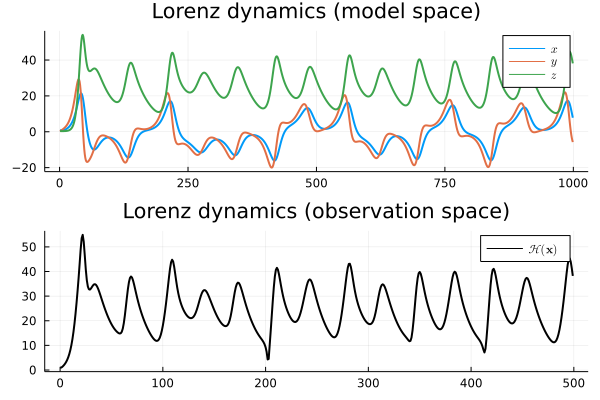

In [3]:
# We can `integrate` a trajectory of the system in its model and observation spaces from an initial condition
random_microstate = rand(state_dim) 
num_observations = 500
simulation = Initialization.integrate( system, random_microstate, num_observations )

# `Initialization.integrate` returns an `Initialization.Simulation` type, which contains:
# the microstate dynamics of the system (.microstates)::AbstractArray, 
# the observation dynamics (.macrostates)::AbstractArray
# the time indexes of the observations (.time)::AbstractArray
p1 = plot( simulation.microstates, lab=[L"x" L"y" L"z"], title="Lorenz dynamics (model space)", lw=2 )
p2 = plot( simulation.time, simulation.macrostates, c=:black, lab=L"\mathcal{H}(\mathbf{x})", title="Lorenz dynamics (observation space)", lw=2)

plot(p1,p2, layout=(2,1))

<img src="lorenz_dynamics.svg" />

In the last cell, we show an example trajectory of the Lorenz system in the model space (the space of the state variables) and the observation space (the space we get after applying the observation operator). 

We used the dedicated function `integrate` that computes the solution of the `system` given an initial condition. `integrate` returns a `Simulation <: Dynamics` object, which contains 1) the model space dynamics (`simulation.microstates`), 2) the observation space dynamics (`simulation.macrostates`), and 3) the time indexes of the observations (`simulation.times`). Note that `simulation.microstates` has $m$ times the datapoints that `simulation.macrostates` have.

See `?Initialization.integrate` for details. 

## Observations

With the model and observation operator at hand, we generate **synthethic observations** of the system. To do so, we consider observations $\mathbf{y} = (y_1, \dots, y_T)$ of the form
\begin{align*}
 y_k &= \mathcal{H}(\mathbf{x}_k) + \epsilon_k \\ 
 \mathbf{x}_k &= f^{mk}(\mathbf{x}_0),
\end{align*}
with $\mathbf{x}_0$ the ground-truth initial condition and $\epsilon_k \sim \mathcal{N}(0, \sigma_n^2)$, with $\sigma_n$ the *spread*, or standard deviation, of the noise in the observations. 

We take $T = 100$ observations and $\sigma_n = 0.3 \sigma_y$, i.e., the noise level of the observations is $30 \%$ of their spread, $\sigma_y = std(\mathbf{y})$. 

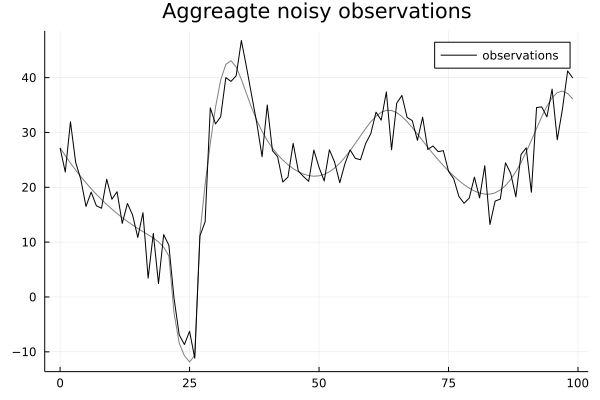

In [4]:
# For reproducibility, we consider a fixed seed of the random number generators. You can set seed=nothing to change this. 
seed = 182

# We made a simple script with a dedicated function that generates synthetic observations.
include("generate_observations.jl")


num_observations = 100 # T
noise_level = 0.3 # with respect to the std of the dynamics

# The generated `data` is just an array with the noisy observations
# `groundtruth` is a Initialization.Simulation that contains the true latent state dynamics and the clean observations
groundtruth, data = generate_observations( system, num_observations, noise_level, seed=seed ) 

plot(groundtruth.time, groundtruth.macrostates, lab="", c=:grey) # observations without noise
plot!(groundtruth.time, data, c=:black, lab="observations", title="Aggreagte noisy observations")

<img src="lorenz_observations.svg" />

## Initialization procedure

Now that we have the data, we test our initialization procedure. It consists of three main steps: 1) **preprocess** the data to reduce noise, 2) **bound** the search space by exploring the attractor(s), and 3) **refine** the estimations using gradient descent optimizers. 

All of these steps are packaged into the single function `initialize`. It depends on parameters $q$, or`smoothing_strength`, (for the preprocess step), $\alpha_R$ and $\beta_R$ (for the bound step), and $\alpha_r$ and $\beta_r$ (for the refine step). See the paper for details.

In [5]:
# Take initial random guess of the latent states
initial_guess = rand(state_dim)

# Parameters of the method: should always be of this order
α_R = 0.05 # set α as \alpha<TAB> 
β_R = 0.5
α_r = 1e-4
β_r = 0.2

smoothing_strength = 2


# burn-in round for precompilation
@time Initialization.initialise(
    system, 
    initial_guess, 
    Initialization.Data(data)[1:2];
    α_R=1,
    α_r=1, 
    β_R=1,
    β_r=1,
)

@time initialization_results = Initialization.initialise(
    system, 
    initial_guess, 
    Initialization.Data(data);
    
    α_R=α_R,
    α_r=α_r, 
    β_R=β_R,
    β_r=β_r,
    noise_scaling=noise_level, 
    q=smoothing_strength,
)

  1.985484 seconds (4.56 M allocations: 289.871 MiB, 3.06% gc time, 2.81% compilation time)
  4.459840 seconds (72.80 M allocations: 3.188 GiB, 13.30% gc time, 16.26% compilation time)


Dict{String, Any} with 9 entries:
  "fitted_observations"       => [28.0411, 26.5746, 25.1839, 23.8698, 22.629, 2…
  "initial_guess"             => [0.904359, 0.108436, 0.340455]
  "refinement_costs"          => [0.0814733, 0.0814733, 0.0811775, 0.0808134, 0…
  "initialised_state"         => [11.1644, 4.38042, 36.8412]
  "rough_state_assim"         => [-4.44294, 0.0643535, 28.5716]
  "rough_state"               => [11.1734, 4.96955, 36.3905]
  "preprocessed_observations" => Data{Int64, Float64}(0:99, [26.0329, 26.6049, …
  "initialised_state_assim"   => [-4.18452, 0.0250707, 28.0721]
  "rough_costs"               => [3.0476, 2.95428, 2.85339, 2.75916, 2.67769, 2…

The `initialize` function gives us a dictionary with the main results of the initialization procedure. We plot the results below.

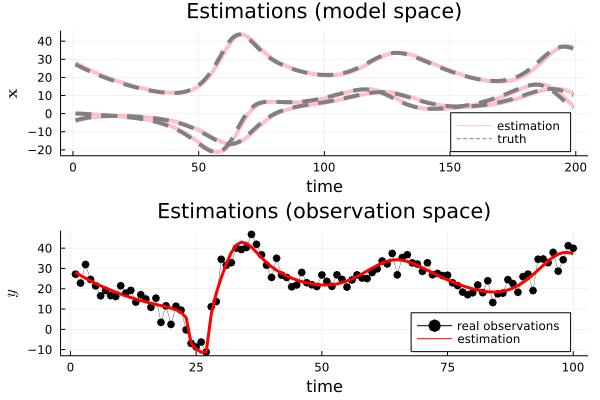

In [6]:
initialiazed_state_assim_time = initialization_results["initialised_state_assim"]
fitted_trajectory = Initialization.integrate(system, initialiazed_state_assim_time, num_observations)
fitted_data = initialization_results["fitted_observations"]

# Model space
plot(fitted_trajectory.microstates, c=:pink, lw=4, lab=["estimation" "" ""])
plot!(groundtruth.microstates, c=:gray, ls=:dash, lw=4, lab=["truth" "" ""])
p1 = plot!(title="Estimations (model space)", xlabel="time", ylabel=L"\mathbf{x}", legend=:bottomright)

# Observation space
plot(data, marker=:o, ms=4, lw=0.3, c=:black, lab="real observations")
plot!(fitted_data, c=:red, lw=3, lab="estimation")
p2 = plot!(title="Estimations (observation space)", xlabel="time", ylabel=L"y", legend=:bottomright)

plot!(p1,p2, layout=(2,1))

<img src="lorenz_estimations_1.svg" />

## Breaking the `initialize` function into parts

In the next code block, we perform the initalization procedure again showing all the intermediate steps so you can get a sense of what is happening inside the code.

For more details, see `?initialize` or the `initialize.jl` script. Also check `?` for the functions introduced in the next block.

In [7]:
## PREPROCESS OBSERVATIONS!
# Reduce the noise in the data using a low-pass moving average filter with `smoothing_strength` number of feedbacks. 
@time data_preprocessed = Initialization.moving_average( Initialization.Data(data), smoothing_strength)

## BOUND SEARCH!
# Explore the attractor to find a rough guess of the microstates based on parameters α_R and β_R
@time x_R_assim, rough_num_steps, rough_costs, rough_sequence = Initialization.initial_guess_search(
    system, 
    initial_guess, 
    data_preprocessed; 
    α_R=α_R, 
    β_R=β_R, 
    noise_scaling=noise_level
)

## REFINE MICROSTATES!
# Refine the rought guess using gradient-based optimizers. how much we refine the search depends on α_r and β_r.
@time refinement_sequence, refinement_costs = Initialization.cost_minimization(
    system, 
    x_R_assim, 
    data_preprocessed;
    α_r=α_r, 
    β_r=β_r, 
    noise_scaling=noise_level,
)

## RESULTS ## 

# initialised microstates (at assimilation time t = t_{-T})
x_star_assim = refinement_sequence[end]
# initialised microstates (at present time t = t_{0})
x_star = Initialization.compute_present_state(system, x_star_assim, data_preprocessed)
# rough guess (at present time)
x_R    = Initialization.compute_present_state(system, x_R_assim, data_preprocessed)

# fitted data
y_star = Initialization.integrate(system, x_star_assim, length(data_preprocessed)).macrostates

# fitted state trajectory 
fitted_trajectory = Initialization.integrate(system, x_star_assim, num_observations)

  0.000044 seconds (602 allocations: 10.641 KiB)
  0.036488 seconds (18.83 k allocations: 1.524 MiB, 94.30% compilation time)
  3.691951 seconds (71.24 M allocations: 3.073 GiB, 14.82% gc time, 0.66% compilation time)


Main.Initialization.Simulation{Float64, Float64, Float64}(0.0:1.0:99.0, [-3.551546728486399 -0.14233065589607613 28.027454332324893; -3.2106251212273667 -0.13993229589560283 27.285110489882673; … ; 11.772207114000162 5.489566565244097 37.16577774887638; 11.143943059124556 4.355656559384987 36.82093348796111], [28.008430991199422, 26.550428158576377, 25.1669532456542, 23.85767593964252, 22.619596126868633, 21.448986404442483, 20.342260236141826, 19.296273780611934, 18.308375583512234, 17.376366671619515  …  24.95364957381711, 27.010393290930335, 29.222454804788605, 31.488235830740877, 33.66799167670115, 35.58049127914621, 37.020567055397635, 37.80729044571039, 37.84783162451449, 37.178031636756245])

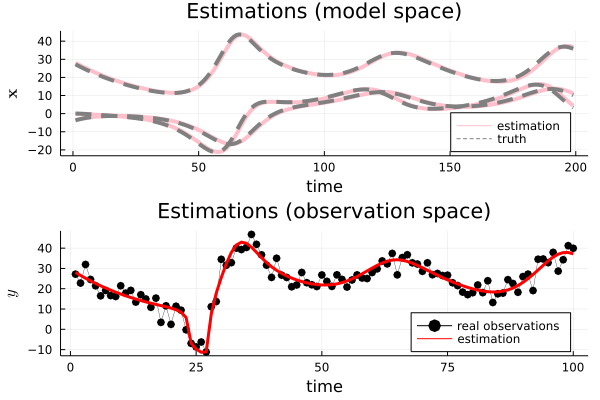

In [8]:
## SAME PLOT AS ABOVE, BUT USING THE BLOCK OF FUNCTIONS RATHER THAN `initialise`.

# Model space
plot(fitted_trajectory.microstates, c=:pink, lw=4, lab=["estimation" "" ""])
plot!(groundtruth.microstates, c=:gray, ls=:dash, lw=4, lab=["truth" "" ""])
p1 = plot!(title="Estimations (model space)", xlabel="time", ylabel=L"\mathbf{x}", legend=:bottomright)

# Observation space
plot(data, marker=:o, ms=4, lw=0.3, c=:black, lab="real observations")
plot!(y_star, c=:red, lw=3, lab="estimation")
p2 = plot!(title="Estimations (observation space)", xlabel="time", ylabel=L"y", legend=:bottomright)

plot!(p1,p2, layout=(2,1))

<img src="lorenz_estimations_2.svg" />

For any questions, do not hesitate to contact us: 

> blas.kolic@maths.ox.ac.uk